In [ ]:
!pip install catboost

In [ ]:
import catboost as cb

In [ ]:
%matplotlib inline


import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, \
    cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, \
    PowerTransformer, StandardScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

# Градиентный бустинг

### Подготовка данных ([соревнование](https://www.kaggle.com/c/home-credit-default-risk/overview)). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [ ]:
# Загрузите таблицу application_train.csv

application_df = pd.read_csv('/content/application_train.csv')

In [ ]:
application_df.shape

(307511, 122)

In [ ]:
application_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Запишите в Y столбец с целевой переменной (TARGET)

X = application_df.drop(['TARGET'], axis=1)
Y = application_df['TARGET']

In [ ]:
# Удалите ненужные столбцы (для этого воспользуйтесь описанием)

import codecs

filename = '/content/HomeCredit_columns_description.csv'
f = codecs.open(filename, 'r', 'cp1251')
u = pd.read_csv(f)
u = u.drop(['Unnamed: 0', 'Special'], axis=1)
u[u['Table'] == 'application_{train|test}.csv']

,Table,Row,Description
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample
1,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,application_{train|test}.csv,CODE_GENDER,Gender of the client
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...,...
117,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...
118,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...
119,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...
120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...


In [ ]:
X.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.0

In [ ]:
X['SK_ID_CURR'].nunique()

307511

In [ ]:
# удалим столбец с ID, т.к. это неинформативный признак

X = X.drop(['SK_ID_CURR'], axis=1)

In [ ]:
# выведем количество отсутствующих значений для каждого признака

x_null = pd.DataFrame(X.isnull().sum()).reset_index(level=0)
x_null.columns=['Column', 'Null_count']
x_null = x_null[x_null['Null_count'] != 0]
x_null.sort_values(by='Null_count')

,Column,Null_count
93,DAYS_LAST_PHONE_CHANGE,1
27,CNT_FAM_MEMBERS,2
7,AMT_ANNUITY,12
8,AMT_GOODS_PRICE,278
40,EXT_SOURCE_2,660
...,...,...
68,NONLIVINGAPARTMENTS_MODE,213514
54,NONLIVINGAPARTMENTS_AVG,213514
60,COMMONAREA_MODE,214865
46,COMMONAREA_AVG,214865


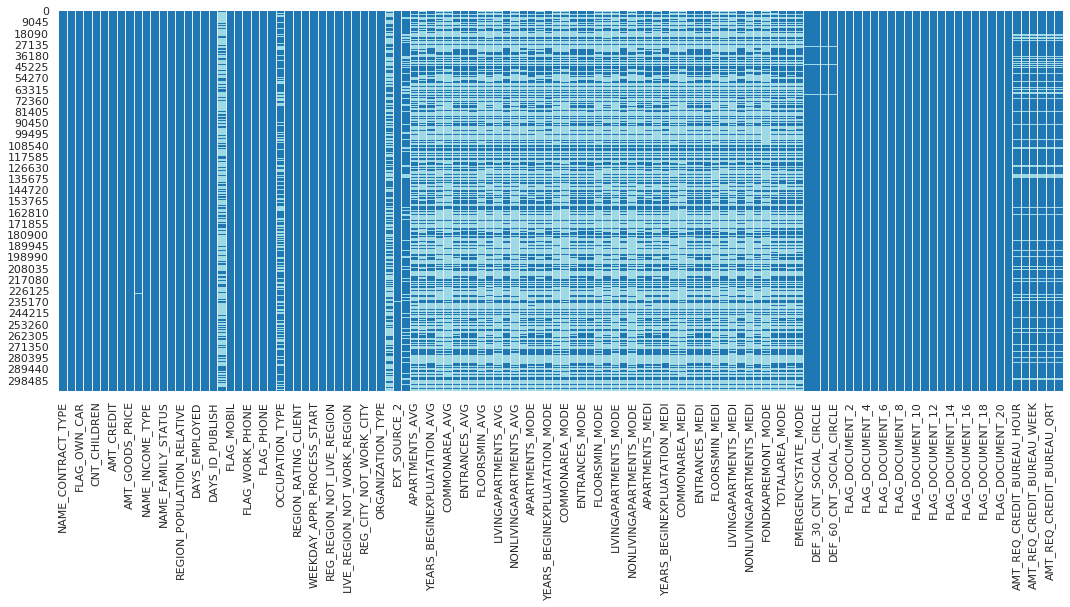

In [ ]:
# посмотрим эти данные на графике

fig, ax = plt.subplots(figsize=(18,7))
sns.heatmap(X.isnull(), cbar=False, cmap="tab20")
plt.show()

In [ ]:
x_null = x_null.pivot_table(index=None, columns='Column', values='Null_count')
x_null

Column,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_LAST_PHONE_CHANGE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,OWN_CAR_AGE,TOTALAREA_MODE,WALLSMATERIAL_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
Null_count,12,278,41519,41519,41519,41519,41519,41519,156061,156061,156061,179943,179943,179943,2,214865,214865,214865,1,1021,1021,163891,163891,163891,145755,154828,154828,154828,173378,660,60965,153020,153020,153020,208642,208642,208642,210295,154297,182590,182590,182590,210199,210199,210199,154350,154350,154350,1292,213514,213514,213514,169682,169682,169682,1021,1021,96391,202929,148431,156341,150007,150007,150007,204488,204488,204488


In [ ]:
X['AMT_REQ_CREDIT_BUREAU_DAY'].isnull().sum()

41519

In [ ]:
# найдем признаки, в которых отсутствует больше 50% значений

features_to_drop = []

for i in x_null.columns:
  if x_null[i][0] > X.shape[0] / 2:
    features_to_drop.append(i)

features_to_drop

['APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE',
 'OWN_CAR_AGE',
 'WALLSMATERIAL_MODE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_MODE']

In [ ]:
# удалим эти признаки

X_2 = X.drop([i for i in features_to_drop], axis=1)

In [ ]:
X_2.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Определите тип столбцов и заполните пропуски - стратегия произвольная

cols_type = pd.DataFrame(X_2.dtypes).reset_index(level=0)
cols_type.columns=['Column', 'Type']
cols_type

,Column,Type
0,NAME_CONTRACT_TYPE,object
1,CODE_GENDER,object
2,FLAG_OWN_CAR,object
3,FLAG_OWN_REALTY,object
4,CNT_CHILDREN,int64
...,...,...
74,AMT_REQ_CREDIT_BUREAU_DAY,float64
75,AMT_REQ_CREDIT_BUREAU_WEEK,float64
76,AMT_REQ_CREDIT_BUREAU_MON,float64
77,AMT_REQ_CREDIT_BUREAU_QRT,float64


In [ ]:
cols_float = cols_type[cols_type['Type'] != 'object']
cols_obj = cols_type[cols_type['Type'] == 'object']

cols_float = list(cols_float['Column'])
cols_obj = list(cols_obj['Column'])

In [ ]:
print('Вещественные признаки:', len(cols_float))
print('Категориальные признаки', len(cols_obj))

Вещественные признаки: 66
Категориальные признаки 13


In [ ]:
# отсутствующие значения количественных признаков заменим на среднее значение

from sklearn.impute import SimpleImputer

imp_float = SimpleImputer(missing_values=np.nan, strategy='mean')
X_2[cols_float] = imp_float.fit_transform(X_2[cols_float])

In [ ]:
# отсутствующие значения категориальных признаков заменим на наиболее частые значения

imp_obj = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_2[cols_obj] = imp_obj.fit_transform(X_2[cols_obj])

In [ ]:
# проверим результат

x_null = pd.DataFrame(X_2.isnull().sum()).reset_index(level=0)
x_null.columns=['Column', 'Null_count']
x_null.sort_values(by='Null_count')

,Column,Null_count
0,NAME_CONTRACT_TYPE,0
56,FLAG_DOCUMENT_5,0
55,FLAG_DOCUMENT_4,0
54,FLAG_DOCUMENT_3,0
53,FLAG_DOCUMENT_2,0
...,...,...
23,FLAG_PHONE,0
22,FLAG_CONT_MOBILE,0
21,FLAG_WORK_PHONE,0
28,REGION_RATING_CLIENT_W_CITY,0


In [ ]:
# Разбейте выборку в соотношении 70:30 с random_state=0

X_train, X_test, y_train, y_test = train_test_split(X_2, Y, test_size=0.3, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(215257, 79)
(215257,)
(92254, 79)
(92254,)


### Из коробки

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.

In [ ]:
# LightGBM

from time import time
from lightgbm import LGBMClassifier
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, average_precision_score

%time
clf_lgbm = LGBMClassifier()
clf_lgbm.fit(X_train[cols_float], y_train)
y_pred = clf_lgbm.predict_proba(X_test[cols_float])[:, 1]

# используем 2 варианта расчета AUC-PR для проверки результатов

precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score = auc(recall, precision)
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score #1: {0:0.2f}'.format(average_precision))
print('AUC-PR score #2: {0:0.2f}'.format(auc_score))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs
AUC-PR score #1: 0.22
AUC-PR score #2: 0.22
Roc-auc score: 0.74


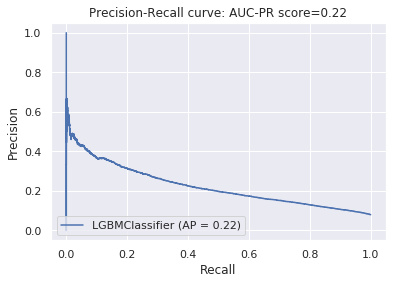

In [ ]:
# выведем график метрики

from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(clf_lgbm, X_test[cols_float], y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AUC-PR score={0:0.2f}'.format(average_precision));

In [ ]:
# Catboost

from catboost import CatBoostClassifier 

%time
clf_cb = CatBoostClassifier(iterations=100)
clf_cb.fit(X_train[cols_float], y_train)
y_pred = clf_cb.predict_proba(X_test[cols_float])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score = auc(recall, precision)
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score #1: {0:0.2f}'.format(average_precision))
print('AUC-PR score #2: {0:0.2f}'.format(auc_score))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
Learning rate set to 0.5
0:	learn: 0.3498001	total: 164ms	remaining: 16.2s
1:	learn: 0.2807839	total: 276ms	remaining: 13.5s
2:	learn: 0.2646765	total: 380ms	remaining: 12.3s
3:	learn: 0.2586942	total: 500ms	remaining: 12s
4:	learn: 0.2564918	total: 623ms	remaining: 11.8s
5:	learn: 0.2551926	total: 731ms	remaining: 11.4s
6:	learn: 0.2545028	total: 845ms	remaining: 11.2s
7:	learn: 0.2540900	total: 955ms	remaining: 11s
8:	learn: 0.2533106	total: 1.07s	remaining: 10.8s
9:	learn: 0.2529589	total: 1.17s	remaining: 10.5s
10:	learn: 0.2526866	total: 1.28s	remaining: 10.4s
11:	learn: 0.2523511	total: 1.4s	remaining: 10.3s
12:	learn: 0.2520725	total: 1.51s	remaining: 10.1s
13:	learn: 0.2518352	total: 1.62s	remaining: 9.95s
14:	learn: 0.2515941	total: 1.74s	remaining: 9.87s
15:	learn: 0.2513674	total: 1.85s	remaining: 9.69s
16:	learn: 0.2511728	total: 1.95s	remaining: 9.54s
17:	learn: 0.2510951	total: 2.06s	remaining: 9.39s
18:	lear

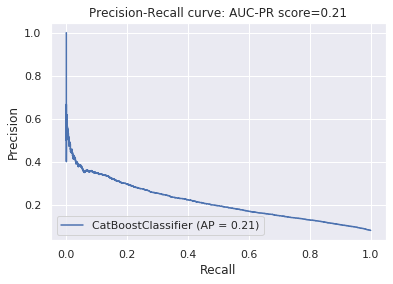

In [ ]:
disp = plot_precision_recall_curve(clf_cb, X_test[cols_float], y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AUC-PR score={0:0.2f}'.format(average_precision));

### Подбор параметров

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма. 

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.39 µs


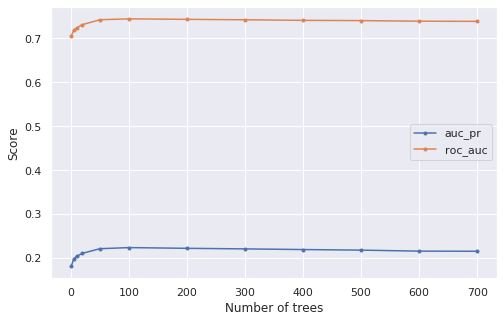

In [ ]:
# количество деревьев
# LightGBM

n_trees = [1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700]
average_precision = []
roc_auc = []

%time
for n in n_trees:
    clf_lgbm = LGBMClassifier(n_estimators=n)
    clf_lgbm.fit(X_train[cols_float], y_train)
    y_pred = clf_lgbm.predict_proba(X_test[cols_float])[:, 1]
    average_precision.append(average_precision_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, average_precision, marker='.', label='auc_pr')
plt.plot(n_trees, roc_auc, marker='.', label='roc_auc')
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.legend()

plt.show()

In [ ]:
lgbm_n_trees = list(zip(n_trees, average_precision))
lgbm_n_trees

[(1, 0.18143105918286279),
 (5, 0.19709316017913142),
 (10, 0.20325429247159074),
 (20, 0.2100640122996601),
 (50, 0.22059739851128735),
 (100, 0.22316138876238975),
 (200, 0.22150743435682618),
 (300, 0.22020861891627425),
 (400, 0.21870702971620484),
 (500, 0.21740310307611002),
 (600, 0.2151145789095184),
 (700, 0.21478270429462992)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Learning rate set to 0.5
0:	learn: 0.3498001	total: 102ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3498001	total: 93ms	remaining: 372ms
1:	learn: 0.2807839	total: 209ms	remaining: 313ms
2:	learn: 0.2646765	total: 309ms	remaining: 206ms
3:	learn: 0.2586942	total: 420ms	remaining: 105ms
4:	learn: 0.2564918	total: 540ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3498001	total: 102ms	remaining: 916ms
1:	learn: 0.2807839	total: 215ms	remaining: 860ms
2:	learn: 0.2646765	total: 316ms	remaining: 737ms
3:	learn: 0.2586942	total: 431ms	remaining: 646ms
4:	learn: 0.2564918	total: 548ms	remaining: 548ms
5:	learn: 0.2551926	total: 658ms	remaining: 438ms
6:	learn: 0.2545028	total: 767ms	remaining: 329ms
7:	learn: 0.2540900	total: 887ms	remaining: 222ms
8:	learn: 0.2533106	total: 997ms	remaining: 111ms
9:	learn: 0.2529589	total: 1.1s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3498001	total: 91.3ms	remaining:

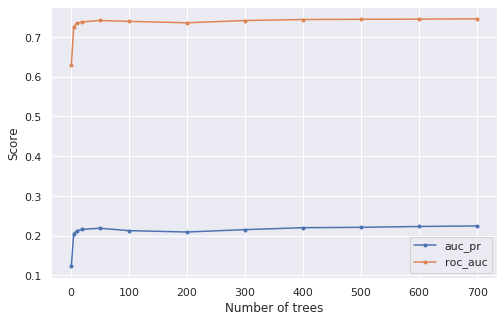

In [ ]:
# количество деревьев
# Catboost

n_trees = [1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600, 700]
average_precision = []
roc_auc = []

%time
for n in n_trees:
    clf_cb = CatBoostClassifier(iterations=n)
    clf_cb.fit(X_train[cols_float], y_train)
    y_pred = clf_cb.predict_proba(X_test[cols_float])[:, 1]
    average_precision.append(average_precision_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, average_precision, marker='.', label='auc_pr')
plt.plot(n_trees, roc_auc, marker='.', label='roc_auc')
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.legend()

plt.show()

In [ ]:
cb_n_trees = list(zip(n_trees, average_precision))
cb_n_trees

[(1, 0.12389368180607872),
 (5, 0.2054254199792825),
 (10, 0.21238391775179047),
 (20, 0.21604390941626764),
 (50, 0.21873652531799345),
 (100, 0.21267451382889052),
 (200, 0.20928682436625323),
 (300, 0.2152341379566337),
 (400, 0.22011045008904112),
 (500, 0.22108519492913656),
 (600, 0.22315654401876922),
 (700, 0.22452649965601834)]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


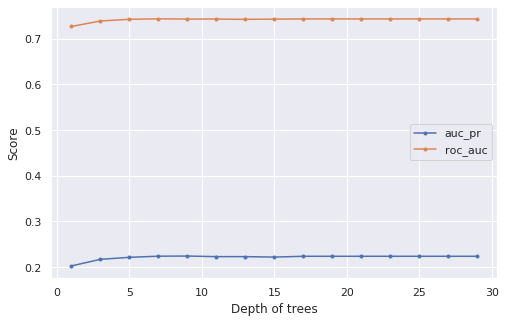

In [ ]:
# глубина деревьев
# LightGBM

%time
depth = list(range(1, 30, 2))
n_trees = 100
average_precision = []
roc_auc = []
for d in depth:
    clf_lgbm = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    clf_lgbm.fit(X_train[cols_float], y_train)
    y_pred = clf_lgbm.predict_proba(X_test[cols_float])[:, 1]
    average_precision.append(average_precision_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    
plt.figure(figsize=(8, 5))
plt.plot(depth, average_precision, marker='.', label='auc_pr')
plt.plot(depth, roc_auc, marker='.', label='roc_auc')
plt.xlabel('Depth of trees')
plt.ylabel('Score')
plt.legend()

plt.show()

In [ ]:
lgbm_depth = list(zip(depth, average_precision))
lgbm_depth

[(1, 0.2019867435550025),
 (3, 0.2164617859469458),
 (5, 0.22087842779959227),
 (7, 0.22335922601042463),
 (9, 0.22368100129924323),
 (11, 0.22240447831043167),
 (13, 0.22239550566010807),
 (15, 0.22140245150846194),
 (17, 0.22316138876238975),
 (19, 0.22316138876238975),
 (21, 0.22316138876238975),
 (23, 0.22316138876238975),
 (25, 0.22316138876238975),
 (27, 0.22316138876238975),
 (29, 0.22316138876238975)]

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 34.8 µs
Learning rate set to 0.141629
0:	learn: 0.5585056	total: 69.5ms	remaining: 48.6s
1:	learn: 0.4715815	total: 139ms	remaining: 48.4s
2:	learn: 0.4092351	total: 214ms	remaining: 49.8s
3:	learn: 0.3666844	total: 281ms	remaining: 48.8s
4:	learn: 0.3367367	total: 346ms	remaining: 48.1s
5:	learn: 0.3172884	total: 413ms	remaining: 47.8s
6:	learn: 0.3026885	total: 482ms	remaining: 47.7s
7:	learn: 0.2930472	total: 549ms	remaining: 47.5s
8:	learn: 0.2859093	total: 616ms	remaining: 47.3s
9:	learn: 0.2804047	total: 683ms	remaining: 47.1s
10:	learn: 0.2768351	total: 759ms	remaining: 47.6s
11:	learn: 0.2741067	total: 823ms	remaining: 47.2s
12:	learn: 0.2720395	total: 893ms	remaining: 47.2s
13:	learn: 0.2702116	total: 960ms	remaining: 47s
14:	learn: 0.2684527	total: 1.04s	remaining: 47.3s
15:	learn: 0.2673742	total: 1.11s	remaining: 47.3s
16:	learn: 0.2662914	total: 1.17s	remaining: 47s
17:	learn: 0.2653515	total: 1.23s	remaining: 46.7s
1

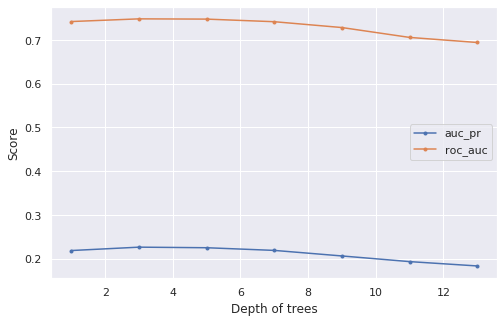

In [ ]:
# глубина деревьев
# Catboost

%time
depth = list(range(1, 14, 2))
n_trees = 700
average_precision = []
roc_auc = []
for d in depth:
    clf_cb = CatBoostClassifier(iterations=n_trees, max_depth=d)
    clf_cb.fit(X_train[cols_float], y_train)
    y_pred = clf_cb.predict_proba(X_test[cols_float])[:, 1]
    average_precision.append(average_precision_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    
plt.figure(figsize=(8, 5))
plt.plot(depth, average_precision, marker='.', label='auc_pr')
plt.plot(depth, roc_auc, marker='.', label='roc_auc')
plt.xlabel('Depth of trees')
plt.ylabel('Score')
plt.legend()

plt.show()

In [ ]:
cb_depth = list(zip(depth, average_precision))
cb_depth

[(1, 0.21876964979254265),
 (3, 0.22648304900867766),
 (5, 0.22517076260568547),
 (7, 0.21906904547710887),
 (9, 0.20638104738297727),
 (11, 0.19345351863785362),
 (13, 0.18355146247448903)]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


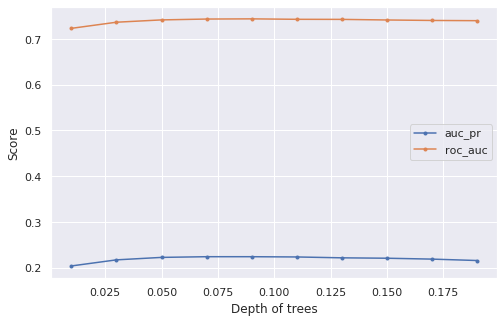

In [ ]:
# темп обучения
# LightGBM

%time
n_trees = 100
depth = 9
learning_rate = list(np.arange(0.01, 0.2, 0.02))
average_precision = []
roc_auc = []
for r in learning_rate:
    clf_lgbm = LGBMClassifier(learning_rate=r, n_estimators=n_trees, max_depth=depth)
    clf_lgbm.fit(X_train[cols_float], y_train)
    y_pred = clf_lgbm.predict_proba(X_test[cols_float])[:, 1]
    average_precision.append(average_precision_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    
plt.figure(figsize=(8, 5))
plt.plot(learning_rate, average_precision, marker='.', label='auc_pr')
plt.plot(learning_rate, roc_auc, marker='.', label='roc_auc')
plt.xlabel('Depth of trees')
plt.ylabel('Score')
plt.legend()

plt.show()

In [ ]:
lgbm_lr = list(zip(learning_rate, average_precision))
lgbm_lr

[(0.01, 0.20359747336831152),
 (0.03, 0.2168984962493909),
 (0.049999999999999996, 0.22229002392483863),
 (0.06999999999999999, 0.22379645646488355),
 (0.08999999999999998, 0.22378555612467643),
 (0.10999999999999997, 0.22323754711045557),
 (0.12999999999999998, 0.2213428182331844),
 (0.15, 0.22047001950140427),
 (0.16999999999999998, 0.21853259650858575),
 (0.18999999999999997, 0.21544624334670875)]

Streaming output truncated to the last 5000 lines.
601:	learn: 0.1180817	total: 9m 49s	remaining: 1m 35s
602:	learn: 0.1178543	total: 9m 50s	remaining: 1m 34s
603:	learn: 0.1177468	total: 9m 51s	remaining: 1m 33s
604:	learn: 0.1175922	total: 9m 52s	remaining: 1m 33s
605:	learn: 0.1174879	total: 9m 53s	remaining: 1m 32s
606:	learn: 0.1173880	total: 9m 54s	remaining: 1m 31s
607:	learn: 0.1172773	total: 9m 55s	remaining: 1m 30s
608:	learn: 0.1172326	total: 9m 56s	remaining: 1m 29s
609:	learn: 0.1170872	total: 9m 57s	remaining: 1m 28s
610:	learn: 0.1169016	total: 9m 58s	remaining: 1m 27s
611:	learn: 0.1168423	total: 9m 59s	remaining: 1m 26s
612:	learn: 0.1167434	total: 10m	remaining: 1m 25s
613:	learn: 0.1165931	total: 10m	remaining: 1m 24s
614:	learn: 0.1164368	total: 10m 1s	remaining: 1m 23s
615:	learn: 0.1163411	total: 10m 2s	remaining: 1m 22s
616:	learn: 0.1162157	total: 10m 3s	remaining: 1m 21s
617:	learn: 0.1161068	total: 10m 4s	remaining: 1m 20s
618:	learn: 0.1159463	total: 10m 5s	r

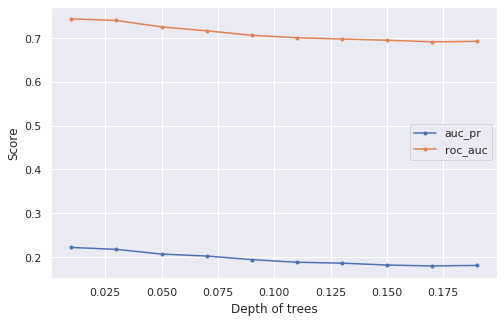

In [ ]:
# темп обучения
# Catboost

%time
n_trees = 700
depth = 3
learning_rate = list(np.arange(0.01, 0.2, 0.02))
average_precision = []
roc_auc = []
for r in learning_rate:
    clf_cb = CatBoostClassifier(learning_rate=r, iterations=n_trees, max_depth=d)
    clf_cb.fit(X_train[cols_float], y_train)
    y_pred = clf_cb.predict_proba(X_test[cols_float])[:, 1]
    average_precision.append(average_precision_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_pred))
    
plt.figure(figsize=(8, 5))
plt.plot(learning_rate, average_precision, marker='.', label='auc_pr')
plt.plot(learning_rate, roc_auc, marker='.', label='roc_auc')
plt.xlabel('Depth of trees')
plt.ylabel('Score')
plt.legend()

plt.show()

In [ ]:
cb_lr = list(zip(learning_rate, average_precision))
cb_lr

[(0.01, 0.22164126504982434),
 (0.03, 0.2171507299342423),
 (0.049999999999999996, 0.2064285025852705),
 (0.06999999999999999, 0.20199429904211313),
 (0.08999999999999998, 0.1937405534303032),
 (0.10999999999999997, 0.18776346779811207),
 (0.12999999999999998, 0.1857095706529605),
 (0.15, 0.18146394240714164),
 (0.16999999999999998, 0.1793570335836947),
 (0.18999999999999997, 0.18060783255715868)]

**Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма**

- Лучшие параметры для LGBMClassifier(learning_rate=0.07, n_estimators=100, max_depth=9)
- Лучшие параметры для CatBoostClassifier(learning_rate=0.01, iterations=700, max_depth=3)

В LGBM соотношение глубины и количества деревьев - 0.09.

В CatBoost - 0.004, т.е. для данного алгоритма требуется меньшая глубина при значительно большем количестве деревьев.

### Кодирование категориальных признаков

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [ ]:
# как OHE признаки

X_dumm = pd.get_dummies(X_2, columns=cols_obj)

In [ ]:
X_dumm.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,...,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262949,0.139376,0.972200,0.083300,0.972200,0.083300,0.972200,0.083300,0.014900,2.0,2.0,2.0,2.0,-1134.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622246,0.510853,0.985100,0.291700,0.985100,0.291700,0.985100,0.291700,0.071400,1.0,0.0,1.0,0.0,-828.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555912,0.729567,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,0.0,0.0,0.0,0.0,-815.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650442,0.510853,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,2.0,0.0,2.0,0.0,-617.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,1.0,1.0,0.322738,0.510853,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,0.0,0.0,0.0,0.0,-1106.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, Y, test_size=0.3, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(215257, 192)
(215257,)
(92254, 192)
(92254,)


In [ ]:
%time
clf_lgbm = LGBMClassifier(learning_rate=0.07, n_estimators=100, max_depth=9)
clf_lgbm.fit(X_train, y_train)
y_pred = clf_lgbm.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
AUC-PR score: 0.24
Roc-auc score: 0.75


In [ ]:
%time
clf_cb = CatBoostClassifier(learning_rate=0.01, iterations=700, max_depth=3)
clf_cb.fit(X_train, y_train)
y_pred = clf_cb.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
0:	learn: 0.6829619	total: 98.1ms	remaining: 1m 8s
1:	learn: 0.6727034	total: 177ms	remaining: 1m 1s
2:	learn: 0.6628833	total: 262ms	remaining: 1m
3:	learn: 0.6530562	total: 354ms	remaining: 1m 1s
4:	learn: 0.6435355	total: 440ms	remaining: 1m 1s
5:	learn: 0.6341182	total: 526ms	remaining: 1m
6:	learn: 0.6250645	total: 624ms	remaining: 1m 1s
7:	learn: 0.6166167	total: 709ms	remaining: 1m 1s
8:	learn: 0.6083282	total: 795ms	remaining: 1m 1s
9:	learn: 0.5999552	total: 885ms	remaining: 1m 1s
10:	learn: 0.5920412	total: 974ms	remaining: 1m 1s
11:	learn: 0.5844020	total: 1.06s	remaining: 1m
12:	learn: 0.5762572	total: 1.16s	remaining: 1m 1s
13:	learn: 0.5686586	total: 1.24s	remaining: 1m
14:	learn: 0.5612558	total: 1.32s	remaining: 1m
15:	learn: 0.5539863	total: 1.43s	remaining: 1m 1s
16:	learn: 0.5469224	total: 1.51s	remaining: 1m
17:	learn: 0.5397532	total: 1.6s	remaining: 1m
18:	learn: 0.5330882	total: 1.7s	remaining: 1m
19

In [ ]:
# как счетчики со сглаживанием

X_smooth = X_2.copy()
Y_smooth = Y.copy()
df_smooth = pd.concat([X_smooth, Y_smooth], axis=1)

In [ ]:
def smooth(df, weight):
  mean = df['TARGET'].mean()
  agg = df.groupby('NAME_CONTRACT_TYPE')['TARGET'].agg(['count', 'mean'])
  counts = agg['count']
  means = agg['mean']
  smooth = (counts * means + weight * mean) / (counts + weight)
  
  return df['NAME_CONTRACT_TYPE'].map(smooth)

In [ ]:
smooth(df_smooth, 100)

0         0.083458
1         0.083458
2         0.054872
3         0.083458
4         0.083458
            ...   
307506    0.083458
307507    0.083458
307508    0.083458
307509    0.083458
307510    0.083458
Name: NAME_CONTRACT_TYPE, Length: 307511, dtype: float64

In [ ]:
mean = df_smooth['TARGET'].mean()
weight = 100
for col in df_smooth[cols_obj].columns:
  agg = df_smooth.groupby(col)['TARGET'].agg(['count', 'mean'])
  counts = agg['count']
  means = agg['mean']
  smooth = (counts * means + weight * mean) / (counts + weight)
  df_smooth.loc[:, col + '_smean_enc'] = df_smooth[col].map(smooth)

for col in cols_obj:
  df_smooth = df_smooth.drop([col], axis=1)

df_smooth.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,NAME_CONTRACT_TYPE_smean_enc,CODE_GENDER_smean_enc,FLAG_OWN_CAR_smean_enc,FLAG_OWN_REALTY_smean_enc,NAME_TYPE_SUITE_smean_enc,NAME_INCOME_TYPE_smean_enc,NAME_EDUCATION_TYPE_smean_enc,NAME_FAMILY_STATUS_smean_enc,NAME_HOUSING_TYPE_smean_enc,OCCUPATION_TYPE_smean_enc,WEEKDAY_APPR_PROCESS_START_smean_enc,ORGANIZATION_TYPE_smean_enc,EMERGENCYSTATE_MODE_smean_enc
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262949,0.139376,0.972200,0.083300,0.972200,0.083300,0.972200,0.083300,0.014900,2.0,2.0,2.0,2.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,1,0.083458,0.101400,0.085000,0.079616,0.081687,0.095875,0.089395,0.098039,0.077958,0.079933,0.081602,0.092978,0.080614
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622246,0.510853,0.985100,0.291700,0.985100,0.291700,0.985100,0.291700,0.071400,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0,0.083458,0.069999,0.085000,0.083247,0.074960,0.057656,0.053587,0.075601,0.077958,0.063103,0.077578,0.059388,0.080614
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.555912,0.729567,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0,0.054872,0.101400,0.072445,0.079616,0.081687,0.095875,0.089395,0.098039,0.077958,0.079933,0.077578,0.069885,0.080614
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650442,0.510853,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,2.0,0.0,2.0,0.0,-617.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006402,0.007,0.034362,0.267395,0.265474,1.899974,0,0.083458,0.069999,0.085000,0.079616,0.081687,0.095875,0.089395,0.099383,0.077958,0.079933,0.081602,0.092978,0.080614
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,11.0,0.0,0.0,0.0,0.0,1.0,1.0,0.322738,0.510853,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_smooth.drop(['TARGET'], axis=1), df_smooth['TARGET'], test_size=0.3, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(215257, 79)
(215257,)
(92254, 79)
(92254,)


In [ ]:
%time
clf_lgbm = LGBMClassifier(learning_rate=0.07, n_estimators=100, max_depth=9)
clf_lgbm.fit(X_train, y_train)
y_pred = clf_lgbm.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
AUC-PR score: 0.24
Roc-auc score: 0.75


In [ ]:
%time
clf_cb = CatBoostClassifier(learning_rate=0.01, iterations=700, max_depth=3)
clf_cb.fit(X_train, y_train)
y_pred = clf_cb.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
0:	learn: 0.6828509	total: 93.1ms	remaining: 1m 5s
1:	learn: 0.6728947	total: 172ms	remaining: 60s
2:	learn: 0.6628677	total: 256ms	remaining: 59.4s
3:	learn: 0.6531212	total: 343ms	remaining: 59.8s
4:	learn: 0.6439139	total: 426ms	remaining: 59.2s
5:	learn: 0.6345473	total: 514ms	remaining: 59.5s
6:	learn: 0.6257520	total: 623ms	remaining: 1m 1s
7:	learn: 0.6171254	total: 709ms	remaining: 1m 1s
8:	learn: 0.6081011	total: 798ms	remaining: 1m 1s
9:	learn: 0.5992307	total: 899ms	remaining: 1m 2s
10:	learn: 0.5913127	total: 981ms	remaining: 1m 1s
11:	learn: 0.5833148	total: 1.07s	remaining: 1m 1s
12:	learn: 0.5754992	total: 1.16s	remaining: 1m 1s
13:	learn: 0.5681611	total: 1.25s	remaining: 1m 1s
14:	learn: 0.5607445	total: 1.34s	remaining: 1m 1s
15:	learn: 0.5533923	total: 1.44s	remaining: 1m 1s
16:	learn: 0.5467047	total: 1.52s	remaining: 1m 1s
17:	learn: 0.5400986	total: 1.61s	remaining: 1m 1s
18:	learn: 0.5333940	total: 1

**Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования?**

Для обучения с кодированием данных при помощи сглаживания время уменьшилось на 10-15%.

In [ ]:
# Сравните полученные результаты с встроенными методами обработки категориальных признаков

X_lgbm = X_2.copy()

for col in X_lgbm.columns:
    col_type = X_lgbm[col].dtype
    if col_type == 'object':
        X_lgbm[col] = X_lgbm[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X_lgbm, Y, test_size=0.3, random_state=0)

%time
clf_lgbm = LGBMClassifier(learning_rate=0.07, n_estimators=100, max_depth=9)
clf_lgbm.fit(X_train, y_train)
y_pred = clf_lgbm.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
AUC-PR score: 0.23
Roc-auc score: 0.75


In [ ]:
X_cb = X_2.copy()

X_train, X_test, y_train, y_test = train_test_split(X_cb, Y, test_size=0.3, random_state=0)

%time
clf_cb = CatBoostClassifier(learning_rate=0.01, iterations=700, max_depth=3)
clf_cb.fit(X_train, y_train, cat_features=cols_obj)
y_pred = clf_cb.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
0:	learn: 0.6826678	total: 287ms	remaining: 3m 20s
1:	learn: 0.6724549	total: 590ms	remaining: 3m 25s
2:	learn: 0.6628369	total: 887ms	remaining: 3m 26s
3:	learn: 0.6531062	total: 1.18s	remaining: 3m 25s
4:	learn: 0.6436738	total: 1.46s	remaining: 3m 22s
5:	learn: 0.6347816	total: 1.8s	remaining: 3m 27s
6:	learn: 0.6256810	total: 2.06s	remaining: 3m 24s
7:	learn: 0.6171472	total: 2.35s	remaining: 3m 23s
8:	learn: 0.6084095	total: 2.65s	remaining: 3m 23s
9:	learn: 0.6000465	total: 2.94s	remaining: 3m 23s
10:	learn: 0.5921519	total: 3.23s	remaining: 3m 22s
11:	learn: 0.5841275	total: 3.52s	remaining: 3m 21s
12:	learn: 0.5766086	total: 3.81s	remaining: 3m 21s
13:	learn: 0.5689243	total: 4.1s	remaining: 3m 20s
14:	learn: 0.5615661	total: 4.37s	remaining: 3m 19s
15:	learn: 0.5543748	total: 4.69s	remaining: 3m 20s
16:	learn: 0.5472599	total: 4.97s	remaining: 3m 19s
17:	learn: 0.5400424	total: 5.25s	remaining: 3m 18s
18:	learn: 0

Встроенные методы обработки категориальных признаков работают не хуже, чем кодирование отдельными методами.

### Стекинг

Реализуйте Стекинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter('ignore')

X_train, X_test, y_train, y_test = train_test_split(X_dumm, Y, test_size=0.3, random_state=0)

clf1 = LGBMClassifier(learning_rate=0.07, n_estimators=100, max_depth=9)
clf2 = CatBoostClassifier(learning_rate=0.01, iterations=700, max_depth=3)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2],
                            meta_classifier=lr)

%time
for clf, label in zip([clf1, clf2, sclf], 
                      ['LGBM', 
                       'CatBoost', 
                       'StackingClassifier']):
    clf.fit(X_train.values, y_train.values)
    y_pred = clf.predict_proba(X_test.values)[:, 1]
    average_precision = average_precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print('AUC-PR score: {0:0.2f}'.format(average_precision.mean()), label)
    print('Roc-auc score: {0:0.2f}'.format(roc_auc.mean()), label)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
AUC-PR score: 0.24 LGBM
Roc-auc score: 0.75 LGBM
0:	learn: 0.6829619	total: 110ms	remaining: 1m 16s
1:	learn: 0.6727034	total: 203ms	remaining: 1m 10s
2:	learn: 0.6628833	total: 301ms	remaining: 1m 9s
3:	learn: 0.6530562	total: 396ms	remaining: 1m 8s
4:	learn: 0.6435355	total: 481ms	remaining: 1m 6s
5:	learn: 0.6341182	total: 565ms	remaining: 1m 5s
6:	learn: 0.6250645	total: 660ms	remaining: 1m 5s
7:	learn: 0.6166167	total: 744ms	remaining: 1m 4s
8:	learn: 0.6083282	total: 829ms	remaining: 1m 3s
9:	learn: 0.5999552	total: 916ms	remaining: 1m 3s
10:	learn: 0.5920412	total: 1.01s	remaining: 1m 3s
11:	learn: 0.5844020	total: 1.1s	remaining: 1m 2s
12:	learn: 0.5762572	total: 1.19s	remaining: 1m 2s
13:	learn: 0.5686586	total: 1.27s	remaining: 1m 2s
14:	learn: 0.5612558	total: 1.35s	remaining: 1m 1s
15:	learn: 0.5539863	total: 1.44s	remaining: 1m 1s
16:	learn: 0.5469224	total: 1.52s	remaining: 1m 1s
17:	learn: 0.5397532	total: 1

- AUC-PR score: 0.24 LGBM
- AUC-PR score: 0.22 CatBoost
- AUC-PR score: 0.09 StackingClassifier

Стекинг работает хуже, чем LGBM и CatBoost по отдельности.

### Важность признаков

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки и обучите модель с теми же параметрами на получившихся данных. Сильно ли упало качество при удалении признаков?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[cols_float], Y, test_size=0.3, random_state=0)

clf_lgbm = LGBMClassifier(learning_rate=0.07, n_estimators=100, max_depth=9)
clf_lgbm.fit(X_train, y_train)

for val, name in sorted(zip(clf_lgbm.feature_importances_, X_train.columns)):
    feat_imp = pd.DataFrame(sorted(zip(clf_lgbm.feature_importances_, X_train.columns)), columns=['Important_value', 'Column'])

In [ ]:
feat_imp

,Important_value,Column
0,0,AMT_REQ_CREDIT_BUREAU_HOUR
1,0,FLAG_DOCUMENT_10
2,0,FLAG_DOCUMENT_12
3,0,FLAG_DOCUMENT_17
4,0,FLAG_DOCUMENT_19
...,...,...
61,227,DAYS_BIRTH
62,232,AMT_ANNUITY
63,241,AMT_GOODS_PRICE
64,292,EXT_SOURCE_2


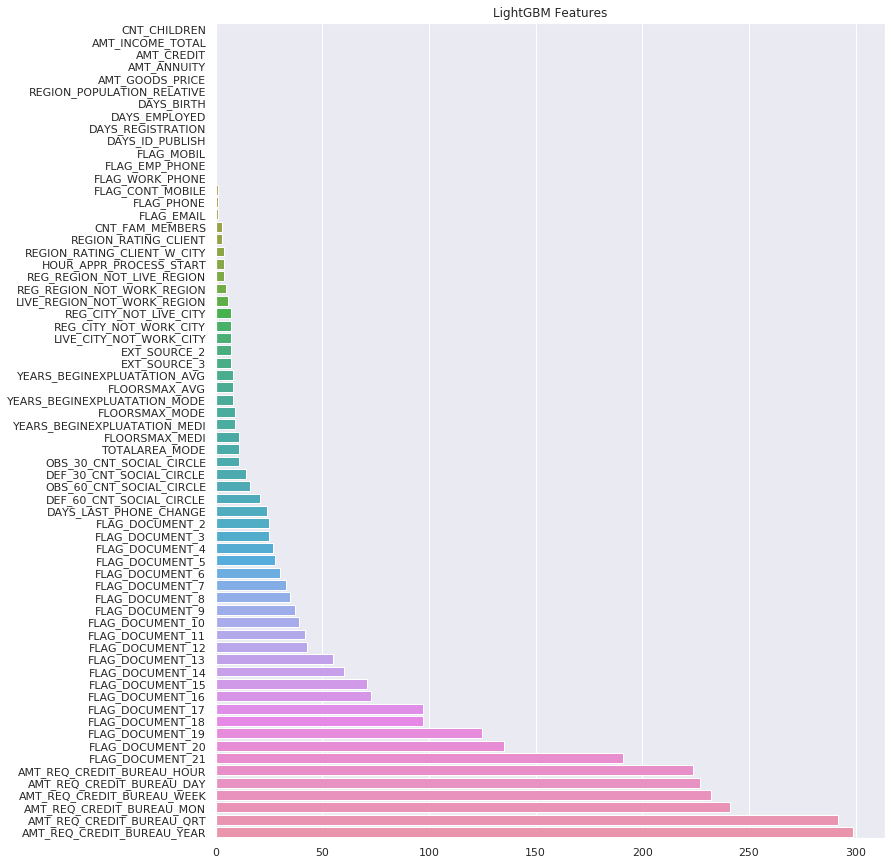

In [ ]:
plt.figure(figsize=(12, 15))
sns.barplot(x=sorted(clf_lgbm.feature_importances_), y=X_train.columns, data=feat_imp, orient='h')
plt.title('LightGBM Features')
plt.show()

In [ ]:
feat_imp_lgbm = feat_imp[feat_imp['Important_value'] > 25]
feat_imp_lgbm = list(feat_imp_lgbm['Column'])

X_train, X_test, y_train, y_test = train_test_split(X[feat_imp_lgbm], Y, test_size=0.3, random_state=0)

%time
clf_lgbm = LGBMClassifier(learning_rate=0.07, n_estimators=100, max_depth=9)
clf_lgbm.fit(X_train, y_train)
y_pred = clf_lgbm.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
AUC-PR score: 0.22
Roc-auc score: 0.74


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[cols_float], Y, test_size=0.3, random_state=0)

clf_cb = CatBoostClassifier(learning_rate=0.01, iterations=700, max_depth=3)
clf_cb.fit(X_train, y_train)

for val, name in sorted(zip(clf_cb.feature_importances_, X_train.columns)):
    feat_imp = pd.DataFrame(sorted(zip(clf_cb.feature_importances_, X_train.columns)), columns=['Important_value', 'Column'])

0:	learn: 0.6825419	total: 87.9ms	remaining: 1m 1s
1:	learn: 0.6718002	total: 188ms	remaining: 1m 5s
2:	learn: 0.6616973	total: 268ms	remaining: 1m 2s
3:	learn: 0.6517541	total: 352ms	remaining: 1m 1s
4:	learn: 0.6421915	total: 433ms	remaining: 1m
5:	learn: 0.6326260	total: 505ms	remaining: 58.4s
6:	learn: 0.6239803	total: 595ms	remaining: 58.9s
7:	learn: 0.6151235	total: 681ms	remaining: 58.9s
8:	learn: 0.6061211	total: 763ms	remaining: 58.6s
9:	learn: 0.5980799	total: 847ms	remaining: 58.4s
10:	learn: 0.5898314	total: 931ms	remaining: 58.3s
11:	learn: 0.5818103	total: 1.01s	remaining: 58.2s
12:	learn: 0.5739798	total: 1.11s	remaining: 58.5s
13:	learn: 0.5663754	total: 1.19s	remaining: 58.1s
14:	learn: 0.5589005	total: 1.26s	remaining: 57.7s
15:	learn: 0.5517005	total: 1.36s	remaining: 58s
16:	learn: 0.5444016	total: 1.44s	remaining: 57.7s
17:	learn: 0.5378898	total: 1.52s	remaining: 57.6s
18:	learn: 0.5309134	total: 1.61s	remaining: 57.9s
19:	learn: 0.5247515	total: 1.69s	remaining: 

In [ ]:
feat_imp

,Important_value,Column
0,0.000000,FLAG_CONT_MOBILE
1,0.000000,FLAG_DOCUMENT_11
2,0.000000,FLAG_DOCUMENT_12
3,0.000000,FLAG_DOCUMENT_14
4,0.000000,FLAG_DOCUMENT_16
...,...,...
61,3.861630,DAYS_EMPLOYED
62,5.152697,DAYS_BIRTH
63,5.596588,AMT_GOODS_PRICE
64,30.134251,EXT_SOURCE_2


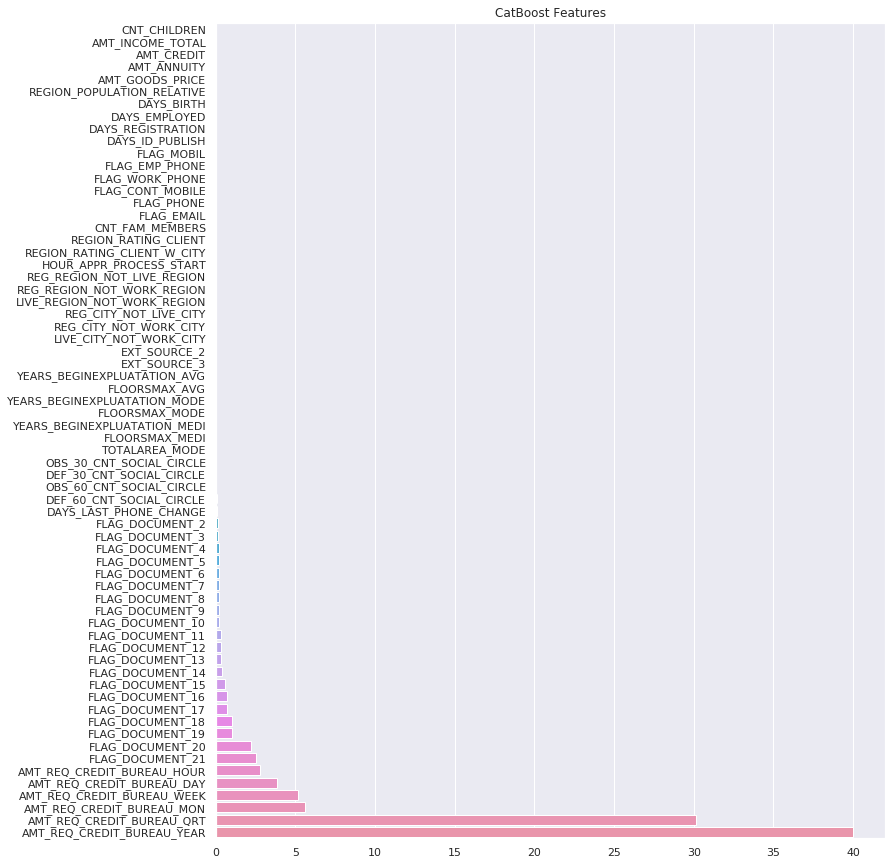

In [ ]:
plt.figure(figsize=(12, 15))
sns.barplot(x=sorted(clf_cb.feature_importances_), y=X_train.columns, data=feat_imp, orient='h')
plt.title('CatBoost Features')
plt.show()

In [ ]:
feat_imp_cb = feat_imp[feat_imp['Important_value'] > 0]
feat_imp_cb = list(feat_imp_cb['Column'])

X_train, X_test, y_train, y_test = train_test_split(X[feat_imp_cb], Y, test_size=0.3, random_state=0)

%time
clf_cb = CatBoostClassifier(learning_rate=0.01, iterations=700, max_depth=3)
clf_cb.fit(X_train, y_train)
y_pred = clf_cb.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print('AUC-PR score: {0:0.2f}'.format(average_precision))
print('Roc-auc score: {0:0.2f}'.format(roc_auc))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
0:	learn: 0.6825775	total: 71.2ms	remaining: 49.8s
1:	learn: 0.6726908	total: 146ms	remaining: 50.9s
2:	learn: 0.6628735	total: 227ms	remaining: 52.6s
3:	learn: 0.6527305	total: 314ms	remaining: 54.6s
4:	learn: 0.6432177	total: 419ms	remaining: 58.2s
5:	learn: 0.6342638	total: 498ms	remaining: 57.6s
6:	learn: 0.6255596	total: 573ms	remaining: 56.8s
7:	learn: 0.6170024	total: 657ms	remaining: 56.8s
8:	learn: 0.6082116	total: 732ms	remaining: 56.2s
9:	learn: 0.5993263	total: 832ms	remaining: 57.4s
10:	learn: 0.5915117	total: 919ms	remaining: 57.6s
11:	learn: 0.5834501	total: 999ms	remaining: 57.3s
12:	learn: 0.5757304	total: 1.09s	remaining: 57.5s
13:	learn: 0.5676183	total: 1.17s	remaining: 57.4s
14:	learn: 0.5605365	total: 1.25s	remaining: 57.1s
15:	learn: 0.5536196	total: 1.33s	remaining: 57s
16:	learn: 0.5465001	total: 1.42s	remaining: 56.9s
17:	learn: 0.5396160	total: 1.5s	remaining: 56.7s
18:	learn: 0.5325391	total: 1.

**Сильно ли упало качество при удалении признаков?**

Качество на обоих алгоритмах упало не сильно.